In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
from matplotlib import pyplot
from scipy.sparse import *
from scipy.stats import loguniform

In [ ]:
urm_path = '/content/data_train.csv'

urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [ ]:
urm_all_df.head(10)

,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
5,1,187,1.0
6,1,205,1.0
7,1,222,1.0
8,1,237,1.0
9,1,354,1.0


In [ ]:
print ("The number of interactions is {}".format(len(urm_all_df)))

The number of interactions is 478730


In [ ]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


**See the distributoin of how many users interacted with one item**

<Axes: >

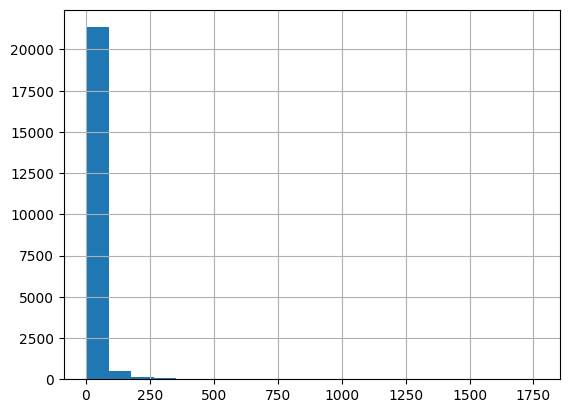

In [ ]:
urm_all_df.groupby(["ItemID"])['UserID'].count().hist(bins=20)

In [ ]:
urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [ ]:
urm_all.tocsr()

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Predictor

Here's the class for our predictor

In [ ]:
!unzip /content/Recommenders.zip

Archive:  /content/Recommenders.zip
   creating: Recommenders/__pycache__/
  inflating: Recommenders/__pycache__/Recommender_utils.cpython-38.pyc  
  inflating: Recommenders/Recommender_utils.py  
   creating: Recommenders/Similarity/
   creating: Recommenders/Similarity/__pycache__/
  inflating: Recommenders/Similarity/__pycache__/Compute_Similarity_Python.cpython-38.pyc  
  inflating: Recommenders/Similarity/Compute_Similarity_Python.py  


In [ ]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
class ItemKNNCFRecommender(object):

    def __init__(self, URM):
        self.URM = URM


    def fit(self, topK=50, shrink=6, normalize=True, similarity="cosine"):

        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink,
                                                  topK=topK, normalize=normalize,
                                                  similarity = similarity)

        self.W_sparse = similarity_object.compute_similarity()


    def recommend(self, user_id, at=None, exclude_seen=True, users_not_in_train=[]):
        # Check if user_id is a valid index
        if user_id < 0 or user_id >= self.URM.shape[0]:
            print(f"Invalid user_id: {user_id}")
            return

        # Check if user_id not in train use the topRec
        if user_id in users_not_in_train:
            return ["517 189 44 0 284 808 285 1 557 1266"]

        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

# Fine-tune the hyperparametrs

In [ ]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_algorithm(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP))
    return MAP, mean_precision, mean_recall

Split the data into train/val


In [ ]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))

val_mask = np.logical_not(train_mask)

urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))

# K-fold Cross-Validatoin


Define the k data partitions for k-folds cross-validation

In [ ]:
from sklearn.model_selection import KFold

n_interactions = urm_all.nnz
num_folds = 10

kf = KFold(n_splits=num_folds,  shuffle = True)
data_folds = []
indices = np.arange(n_interactions)
for train_inc, val_inc in kf.split(indices):
  train_mask = np.full(n_interactions,True)
  train_mask[val_inc] = False
  val_mask = np.logical_not(train_mask)

  fold_urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))
  fold_urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})


**Implement the iterative random hyperparameter search with k-fold cross-validation**

Number of the most similar neighbours to consider

In [ ]:
rnd_k = loguniform.rvs(10, 200, size=11).astype(int)
rnd_shrink = loguniform.rvs(1, 80, size=11).astype(int)
print(rnd_k)
print(rnd_shrink)

[ 83 102  79  13  42 128  33  75  28  25  55]
[ 8 11  4 35  2 10 13 35 13  3  1]


In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "MAP"])
hyperparameter_search_rnd["k"] = rnd_k
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

default_shrink = 5

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = ItemKNNCFRecommender(fold['train'])
      recommender.fit(shrink=default_shrink, topK=hyperparameter_search_rnd.loc[index,"k"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"k"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 22348 (100.0%), 874.24 column/sec. Elapsed time 25.56 sec
Recommender results are: Precision = 501.4000, Recall = 1198.2705, MAP = 0.0643
Fold 1 evaluations started
Similarity column 22348 (100.0%), 1366.44 column/sec. Elapsed time 16.35 sec
Recommender results are: Precision = 491.0000, Recall = 1164.7292, MAP = 0.0649
Fold 2 evaluations started
Similarity column 22348 (100.0%), 1376.96 column/sec. Elapsed time 16.23 sec
Recommender results are: Precision = 497.4000, Recall = 1210.1238, MAP = 0.0664
Fold 3 evaluations started
Similarity column 22348 (100.0%), 1374.23 column/sec. Elapsed time 16.26 sec
Recommender results are: Precision = 503.8000, Recall = 1222.3734, MAP = 0.0676
Fold 4 evaluations started
Similarity column 22348 (100.0%), 1409.34 column/sec. Elapsed time 15.86 sec
Recommender results are: Precision = 502.8000, Recall = 1201.8273, MAP = 0.0664
Fold 5 evaluations started
Similarity column 22348 (100.0%), 1199.38 column/sec. 

      k       MAP
3    13  0.065493
9    25   0.06508
8    28  0.065022
6    33  0.064805
4    42  0.064617
10   55  0.064366
7    75  0.064266
2    79  0.064233
0    83  0.064183
1   102  0.063946
5   128  0.063624


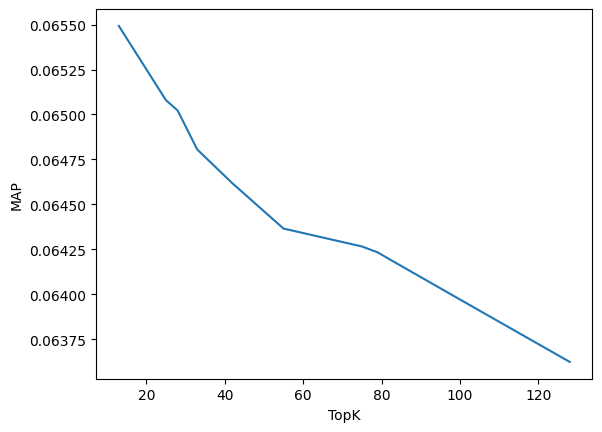

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

Shrinkage

In [ ]:
best_k_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = rnd_shrink
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]


for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = ItemKNNCFRecommender(fold['train'])
      recommender.fit(shrink=hyperparameter_search_rnd.loc[index,"shrink"], topK=best_k_value["k"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"shrink"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 22348 (100.0%), 1410.14 column/sec. Elapsed time 15.85 sec
Recommender results are: Precision = 494.9000, Recall = 1162.9828, MAP = 0.0628
Fold 1 evaluations started
Similarity column 22348 (100.0%), 1533.35 column/sec. Elapsed time 14.57 sec
Recommender results are: Precision = 488.9000, Recall = 1153.4940, MAP = 0.0640
Fold 2 evaluations started
Similarity column 22348 (100.0%), 1369.64 column/sec. Elapsed time 16.32 sec
Recommender results are: Precision = 495.5000, Recall = 1202.3429, MAP = 0.0654
Fold 3 evaluations started
Similarity column 22348 (100.0%), 1402.17 column/sec. Elapsed time 15.94 sec
Recommender results are: Precision = 497.0000, Recall = 1202.5749, MAP = 0.0670
Fold 4 evaluations started
Similarity column 22348 (100.0%), 1448.54 column/sec. Elapsed time 15.43 sec
Recommender results are: Precision = 496.0000, Recall = 1184.3831, MAP = 0.0652
Fold 5 evaluations started
Similarity column 22348 (100.0%), 1441.44 column/sec.

     k  shrink       MAP
10  13       1  0.064577
4   13       2  0.065027
9   13       3  0.065217
2   13       4  0.065404
0   13       8  0.065506
5   13      10  0.065543
1   13      11  0.065474
6   13      13  0.065256
8   13      13  0.065256
3   13      35  0.063285
7   13      35  0.063285


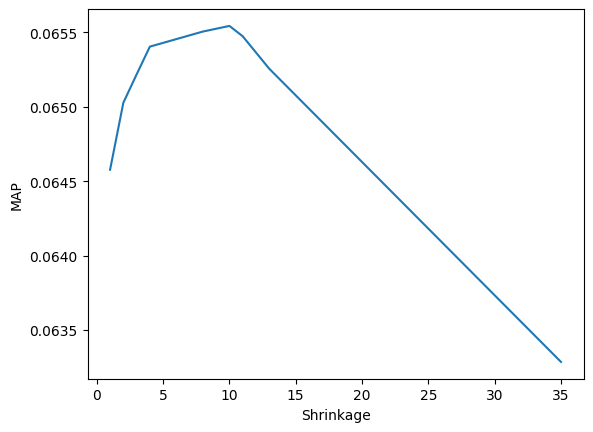

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [ ]:
best_shrink = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_shrink

k               13
shrink          10
MAP       0.065543
Name: 5, dtype: object

Comparing different similarity heuristics

In [ ]:
similarity_heuristic_list = ["cosine", "dice", "jaccard", "pearson"]
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink","similarity", "MAP"])
hyperparameter_search_rnd["similarity"] = similarity_heuristic_list
hyperparameter_search_rnd["k"] = best_k_value["k"]
hyperparameter_search_rnd["shrink"] = best_shrink["shrink"]

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = ItemKNNCFRecommender(fold['train'])
      recommender.fit(shrink=best_shrink["shrink"], topK=best_k_value["k"], similarity = hyperparameter_search_rnd.loc[index,"similarity"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"shrink"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 22348 (100.0%), 1366.99 column/sec. Elapsed time 16.35 sec
Recommender results are: Precision = 497.0000, Recall = 1191.1559, MAP = 0.0638
Fold 1 evaluations started
Similarity column 22348 (100.0%), 1469.59 column/sec. Elapsed time 15.21 sec
Recommender results are: Precision = 492.1000, Recall = 1171.9107, MAP = 0.0650
Fold 2 evaluations started
Similarity column 22348 (100.0%), 1358.60 column/sec. Elapsed time 16.45 sec
Recommender results are: Precision = 497.1000, Recall = 1204.8225, MAP = 0.0664
Fold 3 evaluations started
Similarity column 22348 (100.0%), 1323.73 column/sec. Elapsed time 16.88 sec
Recommender results are: Precision = 500.7000, Recall = 1217.9701, MAP = 0.0674
Fold 4 evaluations started
Similarity column 22348 (100.0%), 1374.73 column/sec. Elapsed time 16.26 sec
Recommender results are: Precision = 499.2000, Recall = 1200.6377, MAP = 0.0660
Fold 5 evaluations started
Similarity column 22348 (100.0%), 1423.03 column/sec.

    k  shrink similarity       MAP
0  13      10     cosine  0.065543
1  13      10       dice  0.065405
2  13      10    jaccard  0.065994
3  13      10    pearson  0.000052


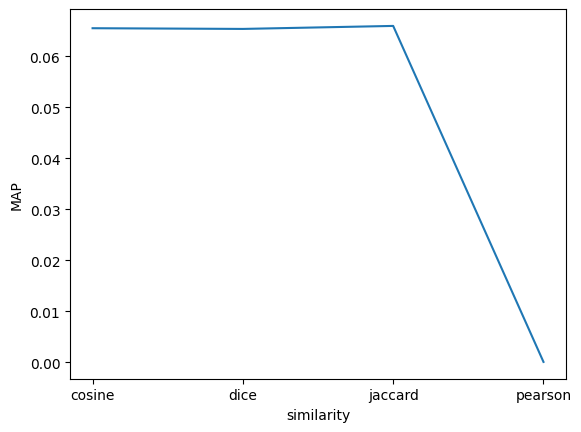

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["similarity"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('similarity')
pyplot.show()

In [ ]:
urm_all_train = sps.csr_matrix((urm_all.data,
                            (urm_all.row, urm_all.col)))

In [ ]:
recommender = ItemKNNCFRecommender(urm_all_train)
recommender.fit(topK = 13,shrink=10)

Similarity column 22348 (100.0%), 1200.62 column/sec. Elapsed time 18.61 sec


**Now let's read the data we want to predict for and see if there're overlaps with UserIDs in train data**

In [ ]:
urm_pred_path = '/content/data_target_users_test.csv'

urm_pred_df = pd.read_csv(filepath_or_buffer=urm_pred_path,
                                sep=",",
                                header=0,
                                dtype={0:int},
                                engine='python')

urm_pred_df.columns = ["UserID"]
len(urm_pred_df['UserID'])
print('Unique user id to predict:', urm_pred_df['UserID'].nunique())

Unique user id to predict: 10882


**Now we make the predictions for every user in our test set and add them to pred_df**

Here we list the users that are in our test set but not in our whole train set

In [ ]:
users_not_in_train = urm_pred_df[~urm_pred_df['UserID'].isin(urm_all_df['UserID'])]

print("Users in urm_pred_df but not in urm_all_orgdf:")
print(users_not_in_train)
print(len(users_not_in_train))

users_not_in_train = users_not_in_train['UserID'].to_numpy()

Users in urm_pred_df but not in urm_all_orgdf:
       UserID
54         60
58         65
147       168
223       261
272       316
...       ...
10682   12775
10699   12798
10729   12837
10802   12921
10856   12992

[221 rows x 1 columns]
221


In [ ]:
usr_id_notintrain = 60
recommendations = recommender.recommend(usr_id_notintrain, at=10, users_not_in_train=users_not_in_train)
print(recommendations)

['517 189 44 0 284 808 285 1 557 1266']


In [ ]:
pred_df = pd.DataFrame(columns = ['user_id','item_list'])

for userid in urm_pred_df['UserID']:
  recommendations = recommender.recommend(userid, at=10,exclude_seen = True, users_not_in_train=users_not_in_train)
  recommendations = " ".join(str(item) for item in recommendations)
  pred_df.loc[len(pred_df)] = [userid,recommendations]

In [ ]:
pred_df

,user_id,item_list
0,1,36 101 403 506 515 977 1546 869 922 1338
1,2,1095 47 11 28 50 12 5 136 277 1522
2,3,59 956 584 259 536 648 857 1281 414 2748
3,4,28 50 249 145 136 277 5 639 679 1146
4,5,1570 77 116 148 5138 7033 175 170 9039 238
...,...,...
10877,13020,6450 6198 6452 6749 7395 7394 4323 15943 161 403
10878,13021,6179 7027 6451 6426 7395 6749 6720 6721 17942 ...
10879,13022,1668 1446 1411 1674 809 21627 10789 1561 1258 ...
10880,13023,1107 639 1124 1146 1534 1273 706 928 1532 1535


In [ ]:
pred_df.to_csv('/content/predIBCFwithCV_Max.csv',index=False)